In [1]:
!pip install POT

     |████████████████████████████████| 430kB 4.9MB/s 


In [0]:
import ot
import torch
import math
import random
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

## Toy Dataset

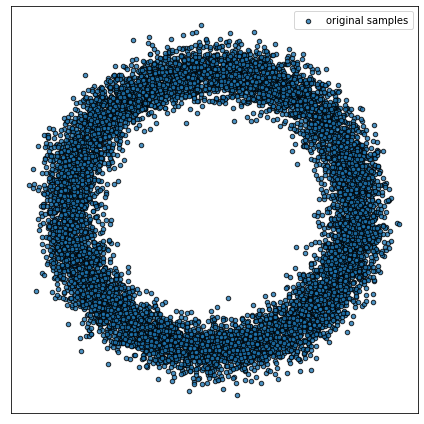

In [3]:
nb_samples = 10000

radius = 1 

nz =.1

# generate the data
X_train = np.zeros((nb_samples,2))
r = np.random.normal(radius,nz,nb_samples)
theta=np.random.rand(nb_samples)*2*np.pi
X_train[:,0]=r*np.cos(theta)
X_train[:,1]=r*np.sin(theta)

plt.figure(figsize=(6,6))
plt.scatter(X_train[:,0], X_train[:,1],s = 20, alpha=0.8, edgecolor = 'k', marker = 'o',label='original samples') 
plt.xticks([], [])
plt.yticks([], [])
plt.legend(loc='best')
plt.tight_layout()

In [0]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [0]:
def generate_images(generator_model, noise_dim, num_samples=1000):
    noise = Variable(Tensor(np.random.normal(0, 1, (num_samples, noise_dim))))
    predicted_samples = generator_model(noise).detach().cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.scatter(X_train[:,0], X_train[:,1],s = 40, alpha=0.2, edgecolor = 'k', marker = '+',label='real samples') 
    plt.scatter(predicted_samples[:,0], predicted_samples[:,1],s = 10, alpha=0.9,c='r', edgecolor = 'k', marker = 'o',label='generated') 
    plt.xticks([], [])
    plt.yticks([], [])
    plt.legend(loc='best')
    plt.show()

A simple fully-connected neural networks class

In [0]:
class NN(nn.Module):
  def __init__(self, dim_inp, hidden_layers, dim_out):
    super(NN, self).__init__()
    self.dim_input = dim_inp
    self.hidden_layers = hidden_layers
    layers = [nn.Linear(self.dim_input, self.hidden_layers[0]), nn.ReLU(inplace=True)]
    for i in range(1, len(self.hidden_layers)):
      layers.append(nn.Linear(self.hidden_layers[i-1], self.hidden_layers[i]))
      layers.append(nn.ReLU(inplace=True))
    layers.append(nn.Linear(self.hidden_layers[-1], dim_out))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

A customized data loader for training

In [0]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        x = self.data[index]
        return x

    def __len__(self):
        return len(self.data)

In [0]:
my_dataset = MyDataset(X_train) # create dataset
my_dataloader = DataLoader(my_dataset, batch_size=128, shuffle=True) # create dataloader

## Wasserstein GAN

In [0]:
class WGAN:
  def __init__(self, generator, discriminator, clip_value, real_data):
      self.generator = generator
      self.discriminator = discriminator
      self.clip_value = clip_value
      self.real_data = real_data  # shape, (nb_examples, n_dims)


  def train(self, data_loader, n_critic, n_epoch, lr):
    """
    data_loader: pytorch dataloader for dataset
    n_critic: number of steps to train critic
    n_epoch: number of training epoch
    lr: learning rate
    """
    records = []
    
    # create two optimizers
    d_optimizer = torch.optim.RMSprop(self.discriminator.parameters(), lr)
    g_optimizer = torch.optim.RMSprop(self.generator.parameters(), lr)
    
    for epoch in range(n_epoch):
    
        ot_results = []
        for i, batch_data in enumerate(data_loader):
            d_optimizer.zero_grad()
            
            # train discriminator, max E(f(x)) - E(f(g(z))) = min E(f(g(z))) - E(f(x))
            f = self.discriminator(Variable(batch_data.type(Tensor)))
            
            # noise
            noise = Variable(Tensor(np.random.normal(0, 1, (batch_data.shape[0], self.generator.dim_input))))
            gz = self.generator(noise).detach()
            fg = self.discriminator(gz)
    
            d_loss = torch.mean(fg) - torch.mean(f)
    
            # optimize discriminator (approximate w1-distance between real distribution and fake distribution)
            # freeze generator
            d_loss.backward()
            d_optimizer.step()
    
            # Clip weights of discriminator
            for p in self.discriminator.parameters():
                p.data.clamp_(-self.clip_value, self.clip_value)
             
            # For each epoch, we draw 10 times iid generated data and real data
            if i == 2:
                exact_ot, s_eps001 = 0, 0
                real_data_sets, generated_data_sets = [], []
                for _ in range(10): # we repeat 10 times
                  # draw iid from data
                  idx = np.random.randint(0, len(self.real_data), size=64)
                  real_data = self.real_data[idx]
                  real_data_sets.append(real_data)
                  # draw iid noise to generate data
                  bruit = Variable(Tensor(np.random.normal(0, 1, (64, self.real_data.shape[1]))))
                  # pass to generator
                  generated_data = self.generator(bruit).detach()
                  generated_data_sets.append(generated_data)
                  # loss matrix
                  M = ot.dist(real_data, generated_data.cpu().numpy(), 'euclidean')
                  M_nor = M / M.max()
                  n, m = M.shape
                  a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples                  
                  exact_ot += M.max()*ot.emd2(a, b, M_nor) 
                  s_eps001 += M.max()*ot.sinkhorn2(a, b, M_nor, 0.01)

                exact_ot /= 10.
                sinkhorn_ot = s_eps001/10.
                
            # records exact ot and apporx ot value
            if i in list(range(2, n_critic)):
                # we feed the same data to updated critic
                approx_ot = 0
                for rl, ge in zip(real_data_sets, generated_data_sets): 
                  val = torch.mean(self.discriminator(Variable(Tensor(rl)))) - torch.mean(self.discriminator(ge))
                  approx_ot += val.item()
                approx_ot /= 10.                                              
                # add to records
                ot_results.append([exact_ot, sinkhorn_ot, approx_ot])
    
            # train generator, min -E(f(g(z))) every n_critic iterations
               
            if i % n_critic == 0:
    
                g_optimizer.zero_grad()
    
                # Generate a batch of images
                gz = self.generator(noise)
                g_loss = -torch.mean(self.discriminator(gz))
    
                g_loss.backward()
                g_optimizer.step()

        
        records.append(ot_results)

        # visualization of intermediate results
        if epoch==0 or (epoch+1)%50==0:
            print("Epoch: ", epoch+1)
            generate_images(self.generator, 2)
    
    return records

In [0]:
generator = NN(2, [128, 64], 2)
discriminator = NN(2, [128], 1)
if cuda:
    generator.cuda()
    discriminator.cuda()

In [0]:
wgan = WGAN(generator, discriminator, 0.3, X_train)

Epoch:  1


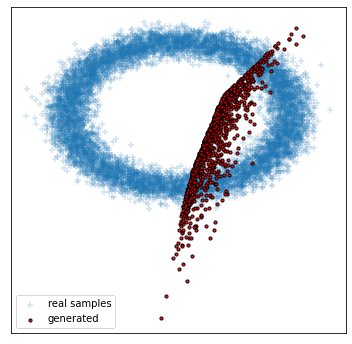

Epoch:  50


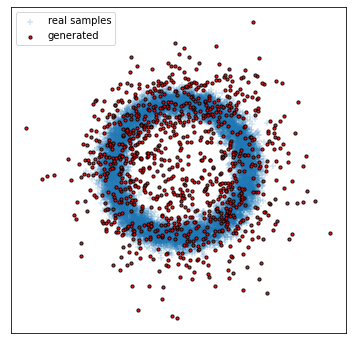

Epoch:  100


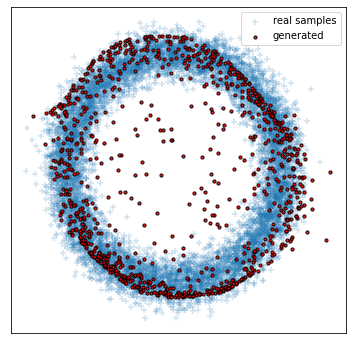

Epoch:  150


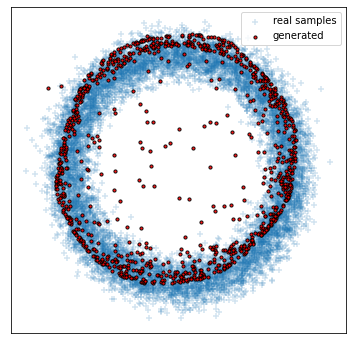

Epoch:  200


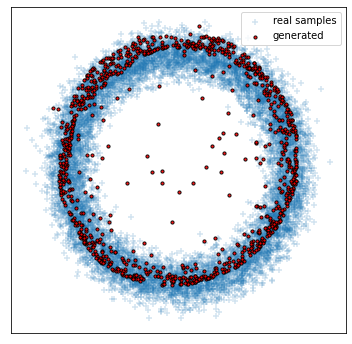

Epoch:  250


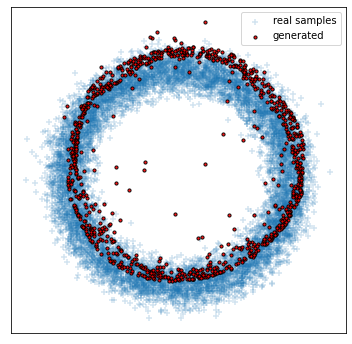

Epoch:  300


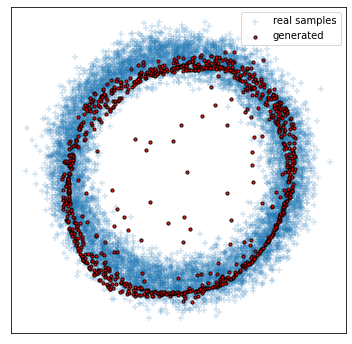

In [81]:
train_records = wgan.train(my_dataloader, 20, 300, lr=0.001)

We plot the empirical approximation of $\mathbb{E}_{x \sim \mathbb{P}_{r}}[f_{\omega}(x)]-\mathbb{E}_{z \sim p(z)}[f_{\omega}(g_{\theta}(z))]  $ given by critic between two successive updates of generator.

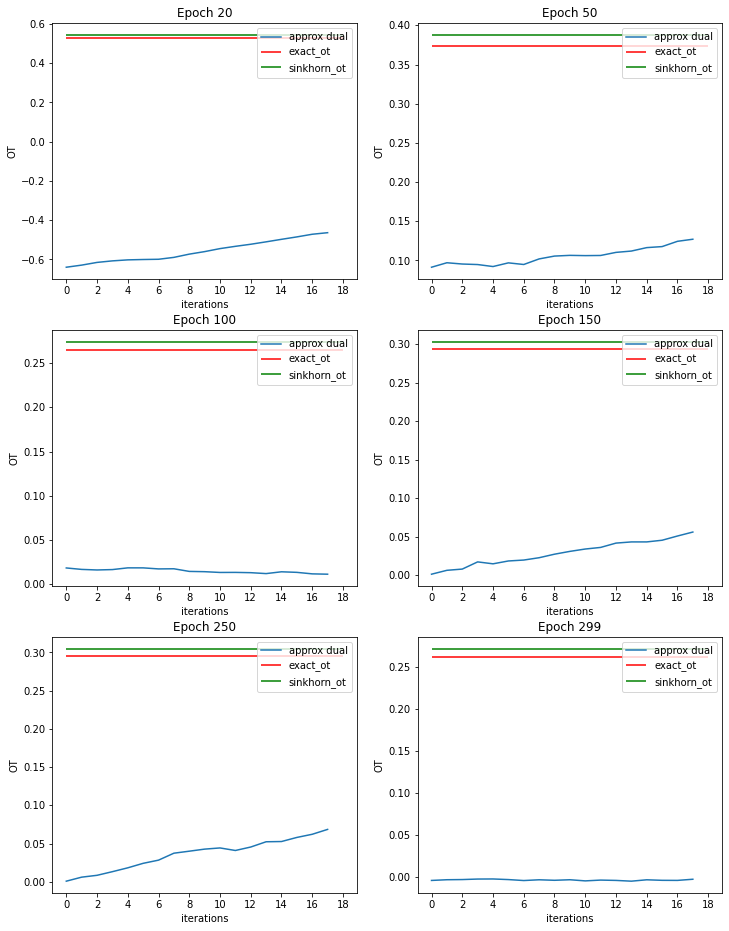

In [82]:
plot_epochs = [20, 50, 100, 150, 250, 299]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,16))
for ax, epo in zip(axes.flatten(), plot_epochs):
  ax.plot(np.array(train_records[epo])[:,2], label='approx dual')
  ax.hlines(train_records[epo][0][0], 0, 18, 'r', label='exact_ot')
  ax.hlines(train_records[epo][0][1], 0, 18, 'g', label='sinkhorn_ot')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.legend(loc='best')
  ax.set_title('Epoch '+str(epo))
  ax.set_xlabel('iterations')
  ax.set_ylabel('OT')

We plot here the evolution of exact OT, sinhkorn OT and approxiamted OT with critic after each epoch.

Text(0.5, 1.0, 'One layer Neural Networks for critic')

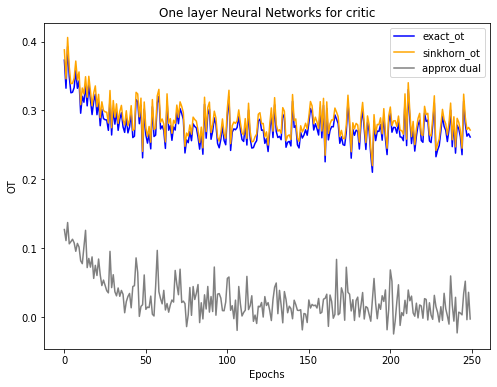

In [86]:
exact_ot = np.array(train_records)[:, 0, 0]
sinkhorn_ot = np.array(train_records)[:, 0, 1]
approx_ot = np.array(train_records)[:, -1, -1]
plt.figure(figsize=(8,6))
plt.plot(exact_ot[50:], 'b', label='exact_ot')
plt.plot(sinkhorn_ot[50:], 'orange', label='sinkhorn_ot')
plt.plot(approx_ot[50:], 'gray', label='approx dual')
plt.xlabel('Epochs')
plt.ylabel('OT')
plt.legend()
plt.title('One layer Neural Networks for critic')

## Generative Model with Sinkhorn Divergence

A Pytorch customized layer that implements Sinkhorn-Knopp Algorithm. It supports the automatic differentiation.

In [0]:
# Adapted from https://github.com/gpeyre/SinkhornAutoDiff
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, p=2, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.p = p
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y, self.p)  # Wasserstein cost function
        x_points = x.shape[-2]  # num points
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).squeeze()

        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sqrt(torch.sum((torch.abs(x_col - y_lin)) ** p, -1) + 1e-8)
        # C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

Generative Model Class

In [0]:
class GenerativeModel_SinkhornDivergence:
  def __init__(self, generator, eps, budget_L, real_data):
    self.generator = generator
    self.reg = eps
    self.budget_L = budget_L
    self.sinkhorn_layer = SinkhornDistance(self.reg, self.budget_L)
    self.real_data = real_data

  def train(self, data_loader, n_epoch, lr):
      records = []
      g_optimizer = torch.optim.Adam(self.generator.parameters(), lr)
      for epoch in range(n_epoch):
          for i, batch_data in enumerate(data_loader):
              batch_size = batch_data.shape[0]
              g_optimizer.zero_grad()
              # Generate a batch of samples
              noise = Variable(Tensor(np.random.normal(0, 1, (batch_size, self.generator.dim_input))))
              gz = self.generator(noise)
              # real data
              real = Variable(batch_data.type(Tensor))
              # sinkhorn divergence
              g_loss = 2*self.sinkhorn_layer(real, gz) - self.sinkhorn_layer(real, real) - self.sinkhorn_layer(gz, gz)
              g_loss.backward()
              g_optimizer.step()             

          # evaluate OT value
          exact_ot, sinkhorn_ot = 0, 0
          for _ in range(10): # we repeat 10 times
              # draw iid from data
              idx = np.random.randint(0, len(self.real_data), size=64)
              real_data = self.real_data[idx]
              # draw iid noise to generate data
              bruit = Variable(Tensor(np.random.normal(0, 1, (64, self.real_data.shape[1]))))
              # pass to generator
              generated_data = self.generator(bruit).detach()
              # loss matrix
              M = ot.dist(real_data, generated_data.cpu().numpy(), 'euclidean')
              M_nor = M / M.max()
              n, m = M.shape
              a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples                  
              exact_ot += M.max()*ot.emd2(a, b, M_nor) 
              
              sinkhorn_ot += self.sinkhorn_layer(Variable(Tensor(real_data)), generated_data).item()

          exact_ot /= 10.
          sinkhorn_ot /= 10.
          records.append([exact_ot, sinkhorn_ot])

          # visualization of intermediate results
          if epoch==0 or (epoch+1)%50==0:
              print("Epoch: ", epoch+1)
              generate_images(self.generator, 2)

      return records

In [0]:
generator = NN(2, [128, 64], 2)
if cuda:
    generator.cuda()

Epoch:  1


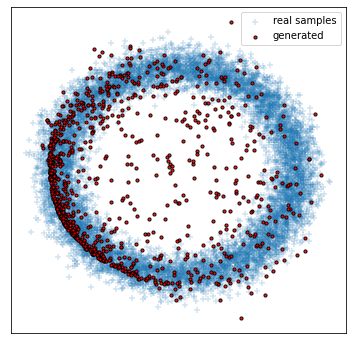

Epoch:  50


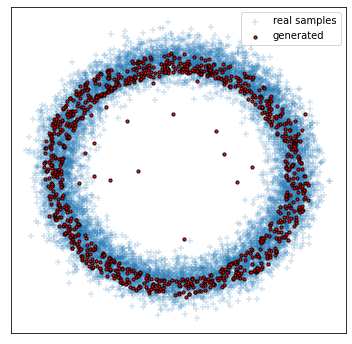

Epoch:  100


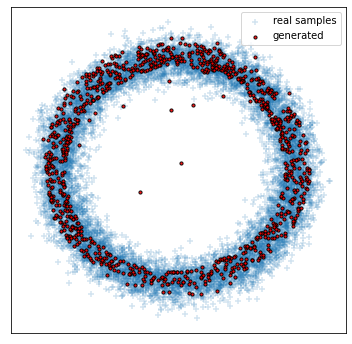

In [32]:
generative_model_sinkhorn = GenerativeModel_SinkhornDivergence(generator, 0.01, 15, X_train)
records_sinkhorn_eps001 = generative_model_sinkhorn.train(my_dataloader, 100, 0.001)

Text(0, 0.5, 'OT')

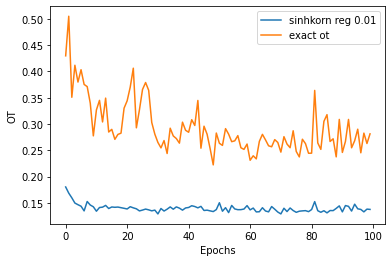

In [34]:
plt.plot(np.array(records_sinkhorn_eps001)[:, 1], label='sinhkorn reg 0.01')
plt.plot(np.array(records_sinkhorn_eps001)[:, 0], label='exact ot')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("OT")

Epoch:  1


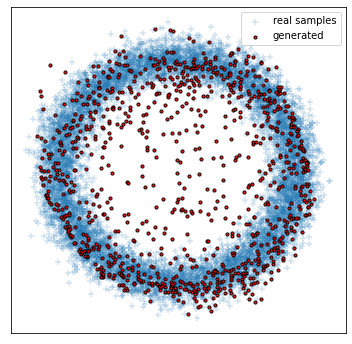

Epoch:  50


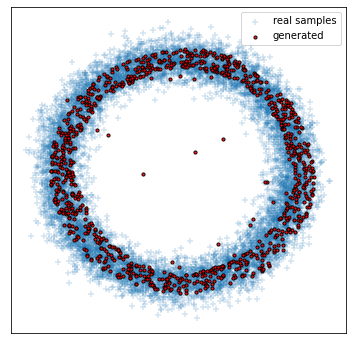

Epoch:  100


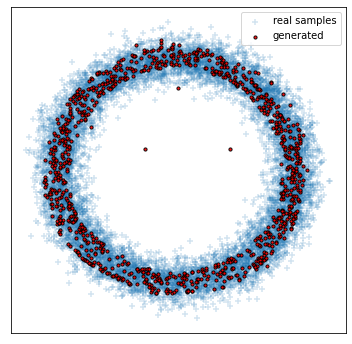

In [35]:
generator = NN(2, [128, 64], 2)
if cuda:
    generator.cuda()

generative_model_sinkhorn = GenerativeModel_SinkhornDivergence(generator, 0.1, 15, X_train)
records_sinkhorn_eps01 = generative_model_sinkhorn.train(my_dataloader, 100, 0.001)

Text(0, 0.5, 'OT')

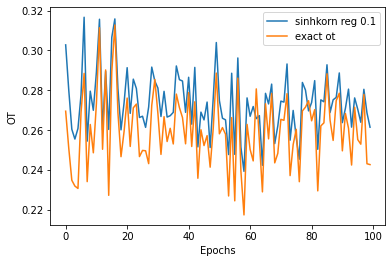

In [36]:
plt.plot(np.array(records_sinkhorn_eps01)[:, 1], label='sinhkorn reg 0.1')
plt.plot(np.array(records_sinkhorn_eps01)[:, 0], label='exact ot')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("OT")

Epoch:  1


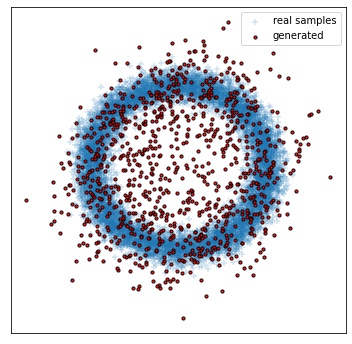

Epoch:  50


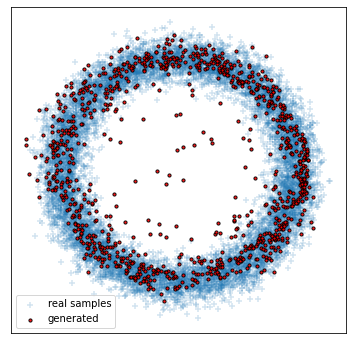

Epoch:  100


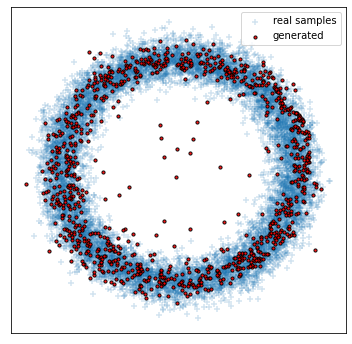

In [37]:
generator = NN(2, [128, 64], 2)
if cuda:
    generator.cuda()

generative_model_sinkhorn = GenerativeModel_SinkhornDivergence(generator, 1., 15, X_train)
records_sinkhorn_eps1 = generative_model_sinkhorn.train(my_dataloader, 100, 0.001)

Text(0, 0.5, 'OT')

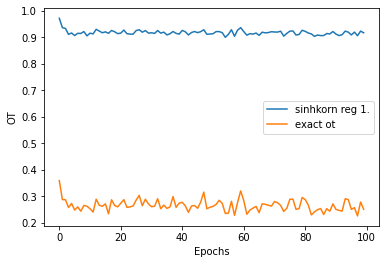

In [39]:
plt.plot(np.array(records_sinkhorn_eps1)[:, 1], label='sinhkorn reg 1.')
plt.plot(np.array(records_sinkhorn_eps1)[:, 0], label='exact ot')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("OT")